# Prepoznavanje spola imena pomoću neuronskih mreža
### Ivan Židov - Računalno jezikoslovlje

In [1]:
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, Flatten, Input
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers.convolutional import Convolution1D, MaxPooling1D
import pandas as pd
import numpy as np
import re
import os
import keras

C:\Users\Ivan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Parametri
maxlen = 15 #najduža duljina riječi, tj. svaka riječ se dopuni s END do duljine 15
labels = 2 #broj klasa, u našem slučaju 2 pošto je samo muško i žensko

## Popis muških i ženskih imena parsiran s https://www.znacenje-imena.com/ 
Pošto ima imena s različitim slovima, ograničili smo na hrvatsku abecedu

In [4]:
myNames=[]
chars = set('abcčćddžđefghijklljmnnjoprsštuvzžABCČĆDDŽĐEFGHIJKLLJMNNJOPRSŠTUVZŽ\n')

with open('muska_imena.txt', 'r',encoding='utf-8') as f:
    #if all((c in chars) for c in (line.strip().lower()):
    myNames = myNames + [(line.strip().lower(),'musko') if all((c in chars) for c in line) else None for line in f]
with open('zenska_imena.txt', 'r',encoding='utf-8') as f:
    myNames = myNames + [(line.strip().lower(),'zensko') if all((c in chars) for c in line) else None for line in f]
myNames = [x for x in myNames if x is not None]
print("U konačnici imamo",len(myNames),"imena")
print(myNames[:4])
print(myNames[-4:])

U konačnici imamo 14113 imena
[('luka', 'musko'), ('david', 'musko'), ('amar', 'musko'), ('daris', 'musko')]
[('aleke', 'zensko'), ('adelais', 'zensko'), ('adelhelma', 'zensko'), ('agnete', 'zensko')]


In [5]:
vocab = set(' '.join([str(i[0]) for i in myNames]))
vocab.add('END')
len_vocab = len(vocab)

In [6]:
print(vocab)
print("Broj slova",len_vocab)

{'o', 'm', 'j', 'a', 'c', 'k', 'u', 'd', 'i', 's', 'END', 'v', 'č', 'h', 'b', 't', 'e', 'n', 'š', 'r', ' ', 'p', 'ž', 'ć', 'z', 'g', 'đ', 'f', 'l'}
Broj slova 29


Indeksirajmo svako slovo kao index

In [7]:
char_index = dict((c, i) for i, c in enumerate(vocab))
print(char_index)

{'o': 0, 'm': 1, 'j': 2, 'a': 3, 'c': 4, 'k': 5, 'u': 6, 'd': 7, 'i': 8, 's': 9, 'END': 10, 'v': 11, 'č': 12, 'h': 13, 'b': 14, 't': 15, 'e': 16, 'n': 17, 'š': 18, 'r': 19, ' ': 20, 'p': 21, 'ž': 22, 'ć': 23, 'z': 24, 'g': 25, 'đ': 26, 'f': 27, 'l': 28}


In [8]:
# Funkcija koja će nam brojati koliko ima muških a koliko ženskih imena u skupu
def muski_zenski(y):
    mc = 0
    zc = 0
    for i in y:
        if i[0]==1:
            mc=mc+1
        else:
            zc=zc+1
    return mc,zc

In [9]:
# Funkcija koja pravi listu duljine broja znakova i na i-tom mjestu je 1 a na svim ostalim 0
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return(tmp)

In [10]:
# Funkciija koja od liste riječi i spola radi vektor 
# gdje je svako slovo zamijenjeno vektorom koji ima 1 na indexu tog slova i ostatak dopuni s END i vektor za spol
def vectorize(parovi):
    X = []
    y = []
    for par in parovi:
        tmp = [set_flag(char_index[j]) for j in str(par[0])]
        for k in range(0,maxlen - len(str(par[0]))):
            tmp.append(set_flag(char_index["END"]))
        X.append(tmp)
        if par[1]=='musko':
            y.append([1,0])
        else:
            y.append([0,1])
    return(X,y)

Promiješamo listu imena

In [11]:
np.random.shuffle(myNames)
print(myNames[:4])
print(myNames[-4:])

[('saranda', 'musko'), ('ortensio', 'musko'), ('hurem', 'musko'), ('orhan', 'musko')]
[('vučan', 'musko'), ('mirac', 'musko'), ('koloman', 'musko'), ('dobrosav', 'musko')]


Razdvojimo imena na skupove za treniranje, validaciju i na test te ih vektoriziramo

In [12]:
train_X,train_y = vectorize(myNames[:12000])
val_X,val_y = vectorize(myNames[12000:13000])
test_X,test_y = vectorize(myNames[13000:14000])

In [13]:
np.array(train_X).shape
print("U trening skupu imamo %d muških imena i %d ženskih imena" % muski_zenski(train_y))

U trening skupu imamo 6005 muških imena i 5995 ženskih imena


## Napravit ćemo 2 modela te ih usporediti

In [87]:
#Prvi model koji je sastavljen od LSTM-ova
print('Radim model1...')
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(maxlen,len_vocab)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64,activation="elu"))
model.add(Dropout(0.5))
#model.add(Dense(16,activation="elu"))
#model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Radim model1...


In [88]:
#Drugi model koji je sastavljen od konvolucijskih jednodimenzionalnih slojeva
print('Radim model2...')
nb_filter = 256
inputs = Input(shape=(maxlen,len_vocab), name='input')

conv = Convolution1D(nb_filter=nb_filter, filter_length=5,
                     border_mode='same', activation='relu',
                     input_shape=(maxlen, len_vocab))(inputs)
conv = MaxPooling1D(pool_length=3)(conv)

conv1 = Convolution1D(nb_filter=nb_filter, filter_length=3,
                      border_mode='same', activation='relu')(conv)
conv1 = MaxPooling1D(pool_length=3)(conv1)

conv5 = Flatten()(conv1)

z = Dropout(0.5)(Dense(64, activation='relu')(conv5))
z = Dropout(0.5)(Dense(16, activation='relu')(z))

pred = Dense(2, activation='softmax', name='output')(z)

model2 = Model(input=inputs, output=pred)

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

Radim model2...


C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(15, 29), filters=256, kernel_size=5, padding="same")`
  
C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  if __name__ == '__main__':
C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=256, kernel_size=3, padding="same")`
  if sys.path[0] == '':
C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  del sys.path[0]
C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


## Treniramo oba modela i s callbackovima najbolje modele spremamo u "model1.h5" i "model2.h5"

In [89]:
callbacks1 = [ModelCheckpoint("model1.h5",monitor="val_loss",save_best_only=True)]
callbacks2 = [ModelCheckpoint("model2.h5",monitor="val_loss",save_best_only=True)]

batch_size=1000
history1 = model.fit(train_X, train_y,batch_size=batch_size,nb_epoch=30,validation_data=(val_X, val_y),callbacks=callbacks1)
history2 = model2.fit(train_X, train_y,batch_size=batch_size,nb_epoch=50,validation_data=(val_X, val_y),callbacks=callbacks2)

Train on 12000 samples, validate on 1000 samples
Epoch 1/30
12000/12000 [==============================] - 6s 529us/step - loss: 0.6844 - acc: 0.5814 - val_loss: 0.6570 - val_acc: 0.6480
Epoch 2/30
12000/12000 [==============================] - 1s 110us/step - loss: 0.6237 - acc: 0.6613 - val_loss: 0.5905 - val_acc: 0.7030
Epoch 3/30
12000/12000 [==============================] - 1s 110us/step - loss: 0.5434 - acc: 0.7367 - val_loss: 0.4993 - val_acc: 0.7660
Epoch 4/30
12000/12000 [==============================] - 1s 111us/step - loss: 0.4993 - acc: 0.7747 - val_loss: 0.4806 - val_acc: 0.7900
Epoch 5/30
12000/12000 [==============================] - 1s 109us/step - loss: 0.4723 - acc: 0.7900 - val_loss: 0.4618 - val_acc: 0.7990
Epoch 6/30
12000/12000 [==============================] - 1s 112us/step - loss: 0.4617 - acc: 0.8012 - val_loss: 0.4528 - val_acc: 0.8100
Epoch 7/30
12000/12000 [==============================] - 1s 112us/step - loss: 0.4474 - acc: 0.8059 - val_loss: 0.4469 - v

C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 12000 samples, validate on 1000 samples
Epoch 1/50
12000/12000 [==============================] - 5s 382us/step - loss: 0.6873 - acc: 0.5371 - val_loss: 0.6633 - val_acc: 0.5780
Epoch 2/50
12000/12000 [==============================] - 1s 60us/step - loss: 0.6253 - acc: 0.6602 - val_loss: 0.5296 - val_acc: 0.8070
Epoch 3/50
12000/12000 [==============================] - 1s 60us/step - loss: 0.5291 - acc: 0.7652 - val_loss: 0.4368 - val_acc: 0.8260
Epoch 4/50
12000/12000 [==============================] - 1s 62us/step - loss: 0.4853 - acc: 0.7941 - val_loss: 0.4138 - val_acc: 0.8310
Epoch 5/50
12000/12000 [==============================] - 1s 61us/step - loss: 0.4518 - acc: 0.8228 - val_loss: 0.3955 - val_acc: 0.8420
Epoch 6/50
12000/12000 [==============================] - 1s 60us/step - loss: 0.4418 - acc: 0.8242 - val_loss: 0.3841 - val_acc: 0.8420
Epoch 7/50
12000/12000 [==============================] - 1s 60us/step - loss: 0.4303 - acc: 0.8372 - val_loss: 0.3670 - val_acc

Učitamo ta dva spremljena modela i usporedimo njihove rezultate na testnim skupovima

In [90]:
model11 = keras.models.load_model('model1.h5')
model22 = keras.models.load_model('model2.h5')
score, acc = model11.evaluate(test_X, test_y)
print('Test score model1:', score)
print('Test accuracy model1:', acc)
score, acc = model22.evaluate(test_X, test_y)
print('Test score model2:', score)
print('Test accuracy model2:', acc)

1000/1000 [==============================] - 1s 1ms/step
Test score model1: 0.37645941638946534
Test accuracy model1: 0.844
1000/1000 [==============================] - 1s 1ms/step
Test score model2: 0.32505844378471377
Test accuracy model2: 0.873


In [91]:
# Funkcija koja vraća matricu konfuzije
def perf_measure(y_actual, y_pred):
    TZ = 0
    FZ = 0
    TM = 0
    FM = 0

    for i in range(len(y_pred)): 
        if y_actual[i][1]==np.round(y_pred[i][1])==1:
           TZ += 1
        if np.round(y_pred[i][1])==1 and y_actual[i][0]==1:
           FZ += 1
        if y_actual[i][0]==np.round(y_pred[i][0])==1:
           TM += 1
        if np.round(y_pred[i][0])==1 and y_actual[i][1]==1:
           FM += 1

    return(TZ, FZ, TM, FM)

In [92]:
print("Tablica konfuzije za model1:")
print("TŽ - Dobro predviđen ženski spol")
print("FŽ - Krivo predviđen ženski spol")
print("TM - Dobro predviđen muški spol")
print("FM - Krivo predviđen muški spol")

df = (pd.DataFrame(data={"Train":perf_measure(train_y,model11.predict(train_X)),"Val":perf_measure(val_y,model11.predict(val_X)),"Test":perf_measure(test_y,model11.predict(test_X))},index=["TŽ","FŽ","TM","FM"]))
print(df)
print()
print("Tablica konfuzije za model1:")
print("TŽ - Dobro predviđen ženski spol")
print("FŽ - Krivo predviđen ženski spol")
print("TM - Dobro predviđen muški spol")
print("FM - Krivo predviđen muški spol")
df = (pd.DataFrame(data={"Train":perf_measure(train_y,model22.predict(train_X)),"Val":perf_measure(val_y,model22.predict(val_X)),"Test":perf_measure(test_y,model22.predict(test_X))},index=["TŽ","FŽ","TM","FM"]))
print(df)

Tablica konfuzije za model1:
TŽ - Dobro predviđen ženski spol
FŽ - Krivo predviđen ženski spol
TM - Dobro predviđen muški spol
FM - Krivo predviđen muški spol
    Test  Train  Val
TŽ   403   4740  400
FŽ    58    647   45
TM   396   4997  403
FM    64    753   73

Tablica konfuzije za model1:
TŽ - Dobro predviđen ženski spol
FŽ - Krivo predviđen ženski spol
TM - Dobro predviđen muški spol
FM - Krivo predviđen muški spol
    Test  Train  Val
TŽ   442   5341  427
FŽ    57    610   63
TM   431   5421  432
FM    70    628   78


Predviđanja za neka proizvoljna imena

In [98]:
name=["ivan","nikita","saša","ana","mitar","duje","tomislav","domagoj","lucija","hrvoje","josipa","hrvoje","mario","martina","nikola","luka","ines"]
X = []
for ime in name:
    tmp = [set_flag(char_index[j]) for j in str(ime)]
    for k in range(0,maxlen - len(str(ime))):
        tmp.append(set_flag(char_index["END"]))
    X.append(tmp)
pred1=model11.predict(np.asarray(X))
pred2=model22.predict(np.asarray(X))

In [99]:
np.set_printoptions(suppress=True)
tab = []
for i in range(len(name)):
    tab.append([name[i],pred1[i],np.argmax(pred1,axis=1)[i],pred2[i],np.argmax(pred2,axis=1)[i]])
pd.DataFrame(tab,columns=["Riječ","Model1","Model1 Predict","Model2","Model2 Predict"])

Riječ                     Model1  Model1 Predict  \
0       ivan   [0.77466303, 0.11581231]               0   
1     nikita   [0.040995177, 0.9571784]               1   
2       saša    [0.2372761, 0.63199055]               1   
3        ana   [0.11938708, 0.94760996]               1   
4      mitar    [0.6773728, 0.16878717]               0   
5       duje    [0.7542483, 0.15416536]               0   
6   tomislav  [0.92543364, 0.028382638]               0   
7    domagoj   [0.9837325, 0.013865337]               0   
8     lucija   [0.46355703, 0.30968243]               0   
9     hrvoje    [0.8366962, 0.11116409]               0   
10    josipa     [0.282441, 0.53616047]               1   
11    hrvoje    [0.8366962, 0.11116409]               0   
12     mario    [0.7505754, 0.13921809]               0   
13   martina  [0.008817128, 0.98290056]               1   
14    nikola   [0.055393416, 0.8881831]               1   
15      luka   [0.11668446, 0.90149593]               1   
16      ines   [0.48556796, 0.32272857]               0   

                       Model2  Model2 Predict  
0     [0.9017982, 0.09820182]               0  
1    [0.10161621, 0.89838374]               1  
2     [0.46524373, 0.5347563]               1  
3      [0.09729397, 0.902706]               1  
4     [0.7710717, 0.22892837]               0  
5    [0.87265754, 0.12734249]               0  
6   [0.9955279, 0.0044720937]               0  
7     [0.985768, 0.014231948]               0  
8     [0.34227368, 0.6577263]               1  
9   [0.95851326, 0.041486736]               0  
10    [0.44037125, 0.5596288]               1  
11  [0.95851326, 0.041486736]               0  
12    [0.9538838, 0.04611614]               0  
13  [0.010217249, 0.98978275]               1  
14   [0.40332338, 0.59667665]               1  
15    [0.27749982, 0.7225002]               1  
16    [0.49584332, 0.5041567]               1

Graf o tome kako su se metrike kretale tijekom vremena za modele
Primjetimo da nakon ~30 epoha je model2 počeo overfittat

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


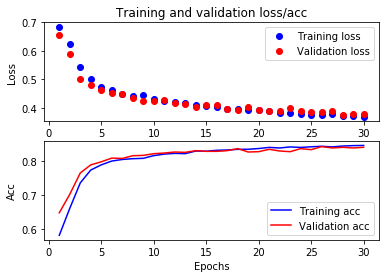

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


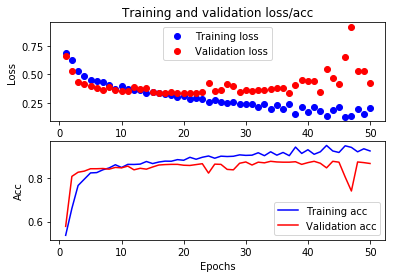

In [95]:
print(history1.history.keys())
loss = history1.history['loss']
val_loss = history1.history['val_loss']
acc = history1.history["acc"]
val_acc = history1.history["val_acc"]
epochs = range(1, len(loss) + 1)
plt.subplot(2,1,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss/acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()
print(history2.history.keys())
loss = history2.history['loss']
val_loss = history2.history['val_loss']
acc = history2.history["acc"]
val_acc = history2.history["val_acc"]
epochs = range(1, len(loss) + 1)
plt.subplot(2,1,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss/acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

Ispis krivo određenih riječi za model1

In [97]:
pred = model11.predict(test_X)
indices = [i for i,v in enumerate(pred) if (np.round(pred[i][0])!=test_y[i][0])]
subset_of_wrongly_predicted = [test_X[i] for i in indices ]
for rijec in (subset_of_wrongly_predicted):
    rij = []
    for slovo in rijec:
        #rij.append(np.nonzero(slovo)[0][0])
        rij.append(list(char_index.keys())[list(char_index.values()).index(np.nonzero(slovo)[0][0])])
    a = ("".join(rij))
    print(re.split("END",a)[0])

keu
till
alais
esther
gerdr
lupita
radiša
richardis
hugh
meral
josianne
leola
nima
morven
fetije
vaistina
sundusa
joann
dalal
maegan
sergije
havin
laza
hercli
zaccaria
zaria
annabell
hussein
jesaja
jake
melih
lestat
ilija
ergin
norgard
billel
aude
nisse
gohar
marion
theodelind
ari
blaža
palle
miles
devonne
ilir
ariele
beltrame
elisud
klio
hoa
joska
santeri
isabell
thomai
redža
maron
pervin
keoma
kiriko
janet
minoo
dinja
cullen
nighils
gladis
mehregaan
arhangel
evje
aahoo
carmine
kerstin
eddie
holger
plutone
asuman
adlai
vule
keziban
jodi
elit
parastu
husein
mirlind
mitja
menahem
ćira
adeen
arseni
bešlaga
annibale
hester
abagail
atvija
plektrudis
senaid
adelmut
špira
laurel
beatriz
fang
hagar
medača
nova
noah
heidrun
bice
nicolai
loke
lepša
kisaki
isiah
pocahontas
duka
elanor
seraphine
pa
mate
seraphina
muhidin
andrija
lentje
tomka
melaheta
arianit
aspen
hrothgar
devontae
novica
marte
kirsten
rin
abele
batoul
tori
bertie
jeremija
katrijn
robaab
jolien
siniša
tamsin
carlisle
šukrija
irin

Ispis krivo određenih riječi za model2

In [96]:
pred = model22.predict(test_X)
indices = [i for i,v in enumerate(pred) if (np.round(pred[i][0])!=test_y[i][0])]
subset_of_wrongly_predicted = [test_X[i] for i in indices ]
for rijec in (subset_of_wrongly_predicted):
    rij = []
    for slovo in rijec:
        #rij.append(np.nonzero(slovo)[0][0])
        rij.append(list(char_index.keys())[list(char_index.values()).index(np.nonzero(slovo)[0][0])])
    a = ("".join(rij))
    print(re.split("END",a)[0])

mae
alais
esther
gerdr
erdmute
lupita
richardis
meral
josianne
leola
nima
morven
fetije
vaistina
iša
sundusa
inger
joann
dalal
sergije
havin
laza
zaccaria
nian
zaria
jesaja
ilija
aude
nisse
gohar
rosel
marion
dilek
palle
ariele
beltrame
klio
hoa
joska
santeri
isabell
redža
blanche
maron
pervin
keoma
kiriko
janet
minoo
dinja
nighils
gladis
mehregaan
evje
aahoo
nataša
carmine
kerstin
khorshid
asuman
sejfi
keziban
jodi
cadence
elit
parastu
mirlind
vukola
mitja
ćira
adeen
arseni
bešlaga
thanh
annibale
hester
abagail
atvija
adelmut
špira
laurel
beatriz
fang
hagar
nova
bice
loke
lepša
michelangelo
pocahontas
duka
elanor
seraphine
pa
seraphina
tomka
melaheta
arianit
aspen
devontae
novica
marte
rin
abele
batoul
tori
bertie
djannah
jeremija
katrijn
robaab
jolien
siniša
tamsin
carlisle
iring
mehtap
benen
nagihan
mića
vujica
sergei
bairre
loek
lenio
suki
skrollan


In [14]:

model22 = keras.models.load_model('model2.h5')
model22.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 54)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 15, 256)           69376     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 5, 256)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 5, 256)            196864    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 256)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                16448     
__________